In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune")
print(os.getcwd())

/gpfs/group/jin/asun/get/3_aggr_m23_finetune


In [2]:
import pandas as pd

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
# get the celltype object based on the configuration
from gcell.cell.celltype import GETHydraCellType

from get_model.config.config import load_config
from get_model.config.config import export_config, load_config_from_yaml

cfg = load_config_from_yaml("interpret_gex_finetune_config.yaml")
#celltype = 'L6 IT' # the celltype you want to load, if you have ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
#hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
#cd14_mono = GETHydraCellType.from_config(cfg, celltype='cd14_mono')


In [41]:
observed_df = pd.DataFrame()
predicted_df = pd.DataFrame()
gene_annot_dict = {}

celltype_for_modeling = ['L6 IT',
                         'Astro']

# Load all cell types
for celltype in celltype_for_modeling:
    try:
        cfg.dataset.leave_out_celltypes = celltype
        hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype)
        gene_annot = hydra_celltype.gene_annot
        gene_annot_dict[celltype] = gene_annot
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

# Intersect all gene indices to get common gene list
common_genes = set.intersection(*[set(g['gene']) for g in gene_annot_dict.values()])

# Extract observed/predicted into two matrices (genes x celltypes)
for celltype in celltype_for_modeling:
    df = gene_annot_dict[celltype].loc[list(common_genes)]
    observed_df[celltype] = df["obs"]
    predicted_df[celltype] = df["pred"]

Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/L6 IT.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/Astro.zarr


KeyError: 'gene'

In [42]:
# Intersect all gene indices to get common gene list
common_genes = set.intersection(*[set(g['gene_name']) for g in gene_annot_dict.values()])

# 2. Optionally impose consistent gene order from a reference cell type
ref_gene_order = [g for g in gene_annot_dict['L6 IT']['gene_name'] if g in common_genes]

# 3. Extract observed/predicted into two aligned matrices
observed_df = pd.DataFrame(index=ref_gene_order)
predicted_df = pd.DataFrame(index=ref_gene_order)

# Extract observed/predicted into two matrices (genes x celltypes)

for celltype in celltype_for_modeling:
    df = gene_annot_dict[celltype]
    
    # Set gene as index temporarily
    df_indexed = df.set_index('gene_name')

    # Subset and reindex using consistent order
    df_indexed = df_indexed.loc[ref_gene_order]

    # Fill the expression matrices
    observed_df[celltype] = df_indexed["obs"]
    predicted_df[celltype] = df_indexed["pred"]

ValueError: cannot reindex on an axis with duplicate labels

In [40]:
gene_annot_dict['L6 IT'].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       16615, 16616, 16617, 16618, 16619, 16620, 16621, 16622, 16623, 16624],
      dtype='int64', length=16625)

In [39]:
# Check for equality of gene *values in order*
(gene_annot_dict['L6 IT']['gene_name'].values == gene_annot_dict['Astro']['gene_name'].values).all()

np.False_

In [7]:
len(common_genes)

16625

In [13]:
common_gene_list = set(gene_annot_dict['L6 IT'].index)
for celltype in celltype_for_modeling:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in celltype_for_modeling:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

In [14]:
merged_L6_IT_Astro = pd.merge(gene_annot_dict['L6 IT'], gene_annot_dict['Astro'], on=['gene_name', 'Start'], suffixes=('_L6_IT', '_Astro'))

In [15]:
merged_L6_IT_Astro

overflow encountered in cast


,gene_name,Chromosome_L6_IT,Start,End_L6_IT,Strand_L6_IT,pred_L6_IT,obs_L6_IT,accessibility_L6_IT,Chromosome_Astro,End_Astro,Strand_Astro,pred_Astro,obs_Astro,accessibility_Astro
0,0610009B22Rik,chr11,51688368,51689268,1,1.278472,1.158315,1.0,chr11,51689268,1,1.267617,1.177037,1.0
1,0610010F05Rik,chr11,23633176,23634038,1,2.137679,1.992882,1.0,chr11,23634038,1,2.132011,1.633165,1.0
2,0610010K14Rik,chr11,70237376,70238288,1,1.011866,1.161152,1.0,chr11,70238288,1,0.997905,1.028389,1.0
3,0610012G03Rik,chr16,31948000,31948904,1,1.546405,1.599664,1.0,chr16,31948904,1,1.538525,1.470027,1.0
4,0610025J13Rik,chr4,98320976,98321600,0,0.077847,0.139066,1.0,chr4,98321600,0,0.076655,0.052368,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16620,Zxdc,chr6,90369216,90370040,0,1.422334,1.356058,1.0,chr6,90370040,0,1.414564,1.398436,1.0
16621,Zyg11b,chr4,108300632,108301488,1,2.232100,2.097505,1.0,chr4,108301488,1,2.223785,2.070713,1.0
16622,Zyx,chr6,42349480,42350356,0,0.792358,0.764334,1.0,chr6,42350356,0,0.783092,0.739203,1.0
16623,Zzz3,chr3,152395808,152396704,0,2.053681,1.963145,1.0,chr3,152396704,0,2.054359,2.001934,1.0


In [19]:
predicted_df

,L6 IT,Astro
0,1.278472,1.267617
1,2.137679,2.132011
2,1.011866,0.997905
3,1.546405,1.538525
4,0.077847,0.076655
...,...,...
16620,1.422334,2.089551
16621,2.232100,1.414564
16622,0.792358,2.223785
16623,2.053681,0.783092


In [20]:
merged_L6_IT_Astro['pred_Astro']

0        1.267617
1        2.132011
2        0.997905
3        1.538525
4        0.076655
           ...   
16620    1.414564
16621    2.223785
16622    0.783092
16623    2.054359
16624    1.267617
Name: pred_Astro, Length: 16625, dtype: float32

In [29]:
common_gene_list = set(gene_annot_dict['L6 IT'].index)
for celltype in celltype_for_modeling:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in celltype_for_modeling:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

In [41]:
gene_annot_dict["L6 IT"]["gene_name"].nunique()

14389

In [36]:
dupes = df[df.duplicated("gene_name",keep=False)]

         gene_name Chromosome      Start        End  Strand      pred  \
32   1500004A13Rik       chr3   88831336   88832104       1  2.032548   
33   1500004A13Rik       chr3   88832256   88833000       1  2.124520   
36   1500011B03Rik       chr5  114813456  114814360       1  1.514459   
37   1500011B03Rik       chr5  114822976  114823856       1  1.388945   
112  1700036A12Rik       chr9   60742516   60742972       0  0.238370   

          obs  accessibility  
32   1.952615            1.0  
33   1.952615            1.0  
36   1.607803            1.0  
37   1.607803            1.0  
112  0.000000            1.0  


overflow encountered in cast


In [38]:
len(dupes)

2660

In [43]:
dupes['gene_name'].nunique()

1216

In [32]:
len(common_gene_list)

15833

In [8]:
celltype_for_modeling = ['L6 IT',
                         'L5 ET',
                         'L5 IT',
                         'L6 CT',
                         'L6b',
                         'Lamp5',
                         'Meis2',
                         'Micro-PVM',
                         'OPC',
                         'Oligo',
                         'Peri',
                         'Pvalb',
                         'Sst',
                         'VLMC',
                         'Vip']

In [9]:
# Extract observed/predicted into two matrices (genes x celltypes)
for celltype in celltype_for_modeling:
    df = gene_annot_dict[celltype].loc[list(common_genes)]
    observed_df[celltype] = df["obs"]
    predicted_df[celltype] = df["pred"]

In [15]:
# Correlation matrices
obs_corr = observed_df.corr(method='pearson')
pred_corr = predicted_df.corr(method='pearson')

In [14]:
len(common_genes)

15833

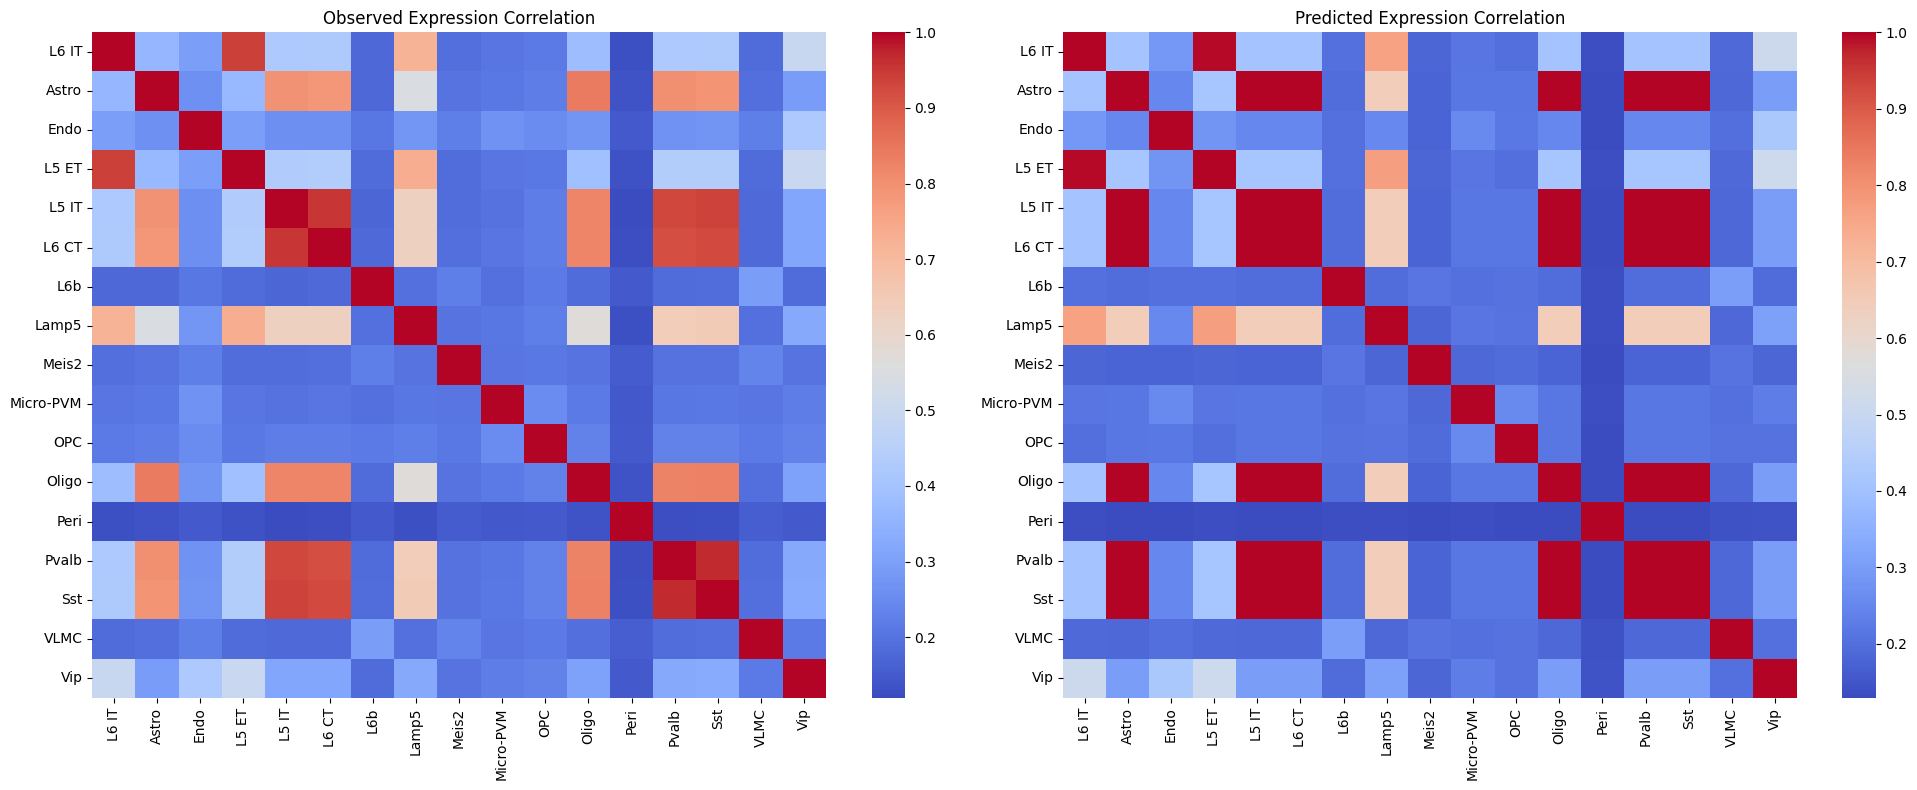

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(obs_corr, cmap="coolwarm", annot=False, ax=axs[0])
axs[0].set_title("Observed Expression Correlation")

sns.heatmap(pred_corr, cmap="coolwarm", annot=False, ax=axs[1])
axs[1].set_title("Predicted Expression Correlation")

plt.tight_layout()
plt.show()

In [8]:
observed_df

,L6 IT,Astro
0,1.158315,1.177037
1,1.992882,1.633165
2,1.161152,1.028389
3,1.599664,1.470027
4,0.139066,0.052368
...,...,...
16620,1.356058,1.939471
16621,2.097505,1.398436
16622,0.764334,2.070713
16623,1.963145,0.739203


In [9]:
predicted_df

,L6 IT,Astro
0,1.278472,1.267617
1,2.137679,2.132011
2,1.011866,0.997905
3,1.546405,1.538525
4,0.077847,0.076655
...,...,...
16620,1.422334,2.089551
16621,2.232100,1.414564
16622,0.792358,2.223785
16623,2.053681,0.783092


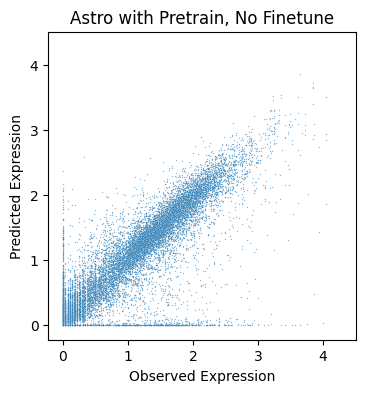

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = observed_df['L6 IT']
y = predicted_df['L6 IT']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

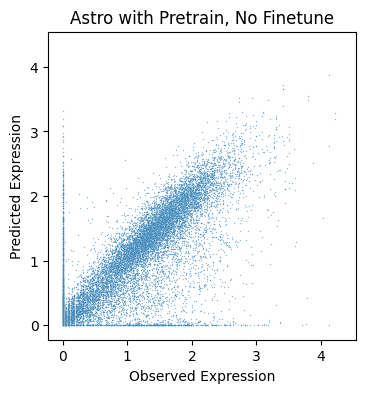

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = observed_df['Astro']
y = predicted_df['Astro']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

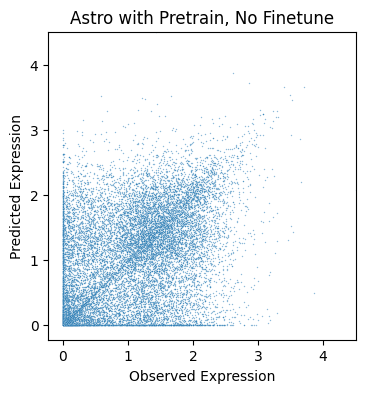

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = predicted_df['L6 IT']
y = predicted_df['Astro']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

In [25]:
type(predicted_df['Astro'])

pandas.core.series.Series

In [26]:
type(merged_L6_IT_Astro['pred_Astro'])

pandas.core.series.Series

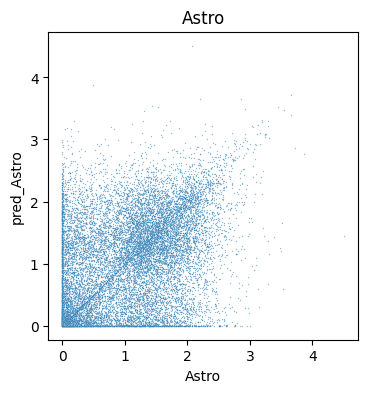

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100


fig, ax = plt.subplots(figsize=(4, 4))

x = predicted_df['Astro']
y = merged_L6_IT_Astro['pred_Astro']

sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro')


plt.show()

In [22]:
np.allclose(predicted_df['Astro'], merged_L6_IT_Astro['pred_Astro'])
(predicted_df['Astro'] - merged_L6_IT_Astro['pred_Astro']).describe()

count    16625.000000
mean        -0.000055
std          0.825383
min         -3.382784
25%         -0.446199
50%          0.000000
75%          0.450812
max          3.068461
dtype: float64

In [23]:
(x.index == y.index).all()

np.True_

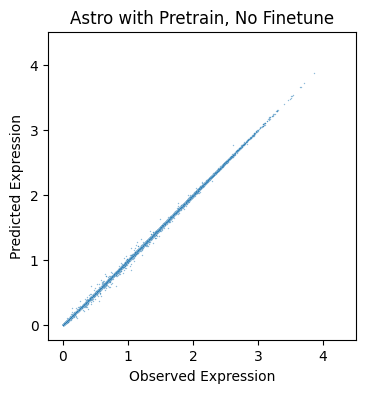

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = merged_L6_IT_Astro['pred_L6_IT']
y = merged_L6_IT_Astro['pred_Astro']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

In [37]:
predicted_df['Astro']

0        1.267617
1        2.132011
2        0.997905
3        1.538525
4        0.076655
           ...   
16620    2.089551
16621    1.414564
16622    2.223785
16623    0.783092
16624    2.054359
Name: Astro, Length: 16625, dtype: float32

In [38]:
merged_L6_IT_Astro['pred_Astro']

0        1.267617
1        2.132011
2        0.997905
3        1.538525
4        0.076655
           ...   
16620    1.414564
16621    2.223785
16622    0.783092
16623    2.054359
16624    1.267617
Name: pred_Astro, Length: 16625, dtype: float32

In [36]:
import numpy as np
import pandas as pd

# Extract Series
x = predicted_df['Astro']
y = merged_L6_IT_Astro['pred_Astro']

# Align indices just to be safe
x, y = x.align(y, join='inner')

# Define a mask for differing rows (outside tolerance)
diff_mask = ~np.isclose(x, y, rtol=1e-05, atol=1e-08)

# Show mismatched values
diff_df = pd.DataFrame({
    'predicted_df': x[diff_mask],
    'merged_df': y[diff_mask],
    'delta': (x - y)[diff_mask]
})

print(f"Number of mismatches: {diff_mask.sum()}")
diff_df.head()

Number of mismatches: 16096


,predicted_df,merged_df,delta
529,0.345088,0.000006,0.345082
530,0.000006,0.269345,-0.269339
531,0.269345,0.001373,0.267973
532,0.001373,0.037391,-0.036019
533,0.037391,0.593473,-0.556081
